In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import Input

def conv_block(input_tensor, num_filters):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = tf.keras.layers.Activation("relu")(x)

    # second layer
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    return x

def encoder_block(input_tensor, num_filters):
    """Function to add 2 convolutional layers with the parameters passed to it and then perform max pooling"""
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    """Function to perform upconvolution and concatenate the upconvolved tensor with the tensor from the contracting path"""
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(input_tensor)
    x = concatenate([x, concat_tensor], axis=-1)
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    """Function to build a U-Net using the functions defined above"""

    inputs = Input(input_shape)

    # Contracting Path (Encoder)
    c1, p1 = encoder_block(inputs, 16)
    c2, p2 = encoder_block(p1, 32)
    c3, p3 = encoder_block(p2, 64)
    c4, p4 = encoder_block(p3, 128)
    
    # Bottleneck
    b = conv_block(p4, 256)

    # Expansive Path (Decoder)
    d1 = decoder_block(b, c4, 128)
    d2 = decoder_block(d1, c3, 64)
    d3 = decoder_block(d2, c2, 32)
    d4 = decoder_block(d3, c1, 16)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Set the input shape (e.g., 128x128x1 for grayscale images)
input_shape = (128, 128, 1)
model = build_unet(input_shape)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()






Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         160       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['activation[0][0]']          
                                                                                          

In [ ]:
import os
import torch
import monai
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImage, AddChannel, ScaleIntensity, ToTensor, RandRotate90
)
from monai.data import DataLoader, Dataset
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from torch.optim import Adam

# Directory where the images and labels are stored
data_dir = "z:/W-People/Nate/Deep_Learning_Data/"

# Function to create a list of image and label pairs
def create_dataset(data_dir):
    images = []
    labels = []
    for filename in os.listdir(data_dir):
        if filename.endswith("image.jpg"):  # Modify as per your image file extension
            image_path = os.path.join(data_dir, filename)
            label_path = os.path.join(data_dir, filename.replace("image", "label"))  # Assuming a consistent naming convention
            images.append(image_path)
            labels.append(label_path)
    return images, labels

# Data Transformations
train_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RandRotate90(),
    ToTensor(),
])

val_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    ToTensor(),
])

# Creating Dataset and DataLoader
train_images, train_labels = create_dataset(data_dir)
val_images, val_labels = create_dataset(data_dir)  # Assuming validation data is in the same directory

train_ds = Dataset(data=list(zip(train_images, train_labels)), transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)

val_ds = Dataset(data=list(zip(val_images, val_labels)), transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1)

# UNet Model Initialization
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
)

# Loss Function and Optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = Adam(model.parameters(), 1e-3)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and Validation Functions
def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0
    for batch_data in loader:
        inputs, targets = batch_data
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def validate_epoch(model, loader, loss_function, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch_data in loader:
            inputs, targets = batch_data
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# Main Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, device)
    val_loss = validate_epoch(model, val_loader, loss_function, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")


In [1]:
import os
import torch
import monai
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImage, AddChannel, ScaleIntensity, ToTensor, RandRotate90, LoadImaged
)
from monai.data import DataLoader, Dataset
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from torch.optim import Adam
import matplotlib.pyplot as plt

print("Setting up directories and initial configurations...")

# Directory where the images and labels are stored
data_dir = "z:/W-People/Nate/Deep_Learning_Data/"


def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):  # Identifies the image files
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")  # Creates the label filename
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts


# Data Transformations
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),  # Load NRRD images and labels
    AddChannel(),
    ScaleIntensity(),
    RandRotate90(prob=0.5),  # Probabilistic rotation for augmentation
    ToTensor(),
])

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChannel(),
    ScaleIntensity(),
    ToTensor(),
])


print("Creating datasets...")
train_files = create_dataset(data_dir)
val_files = create_dataset(data_dir)  # Assuming validation data is in the same directory

train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)

val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1)


# UNet Model Initialization
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
)

# Loss Function and Optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = Adam(model.parameters(), 1e-3)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and Validation Functions
def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0
    for batch_data in loader:
        inputs, targets = batch_data
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def validate_epoch(model, loader, loss_function, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch_data in loader:
            inputs, targets = batch_data
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

train_losses = []
val_losses = []

# Main Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, device)
    val_loss = validate_epoch(model, val_loader, loss_function, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()
plt.show()


ImportError: cannot import name 'AddChannel' from 'monai.transforms' (C:\Users\ndnewcomb\AppData\Roaming\Python\Python311\site-packages\monai\transforms\__init__.py)

In [12]:
import os
import torch
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, ToTensord, RandRotate90d
)
from monai.data import DataLoader, Dataset
from monai.losses import DiceLoss
from torch.optim import Adam
import matplotlib.pyplot as plt
from monai.data import pad_list_data_collate
from monai.transforms import Resized, SpatialPad


# MONAI's transforms for dictionary format use 'd' at the end
# Assuming EnsureChannelFirstd is a valid replacement for AddChannel

print("Setting up directories and initial configurations...")

# Directory where the images and labels are stored
data_dir = "z:/W-People/Nate/Deep_Learning_Data/"

# Function to create a list of image and label pairs
def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):  # Identifies the image files
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")  # Creates the label filename
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts
desired_height, desired_width, desired_depth = 64, 64, 64 #REPLACE WITH RANDOM CROP
print("Creating datasets...")
train_files = create_dataset(data_dir)
val_files = create_dataset(data_dir)  # Assuming validation data is in the same directory


# Data Transformations
print("Defining transformations...")
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    Resized(keys=['image', 'label'], spatial_size=(desired_height, desired_width, desired_depth)),  # Adjusted Resize transform
    ScaleIntensityd(keys=['image', 'label']),
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ToTensord(keys=['image', 'label']),
])

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    Resized(keys=['image', 'label'], spatial_size=(desired_height, desired_width, desired_depth)),  # Adjusted Resize transform
    ScaleIntensityd(keys=['image', 'label']),
    ToTensord(keys=['image', 'label']),
])

train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=pad_list_data_collate)
val_loader = DataLoader(val_ds, batch_size=1, collate_fn=pad_list_data_collate)

# UNet Model Initialization

print("Initializing 3D U-Net model...")

model = UNet(
    spatial_dims=3,  # This specifies that the network should be 3D
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2)
)

# Loss Function and Optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = Adam(model.parameters(), 1e-3)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and Validation Functions
def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0
    for batch_data in loader:
        inputs, targets = batch_data['image'], batch_data['label']
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def validate_epoch(model, loader, loss_function, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch_data in loader:
            inputs, targets = batch_data['image'], batch_data['label']
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# Main Training Loop
train_losses = []
val_losses = []

print("Starting training process...")
num_epochs = 30
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, device)
    val_loss = validate_epoch(model, val_loader, loss_function, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

# Plotting loss curves
print("Plotting loss curves...")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()
plt.show()


Setting up directories and initial configurations...
Creating datasets...
Defining transformations...
Initializing 3D U-Net model...
Starting training process...
Epoch 1/30, Train Loss: 0.6432407200336456, Validation Loss: 0.6313555439313253
Epoch 2/30, Train Loss: 0.6285948157310486, Validation Loss: 0.6184735496838888
Epoch 3/30, Train Loss: 0.6161855757236481, Validation Loss: 0.6075851321220398
Epoch 4/30, Train Loss: 0.6052047312259674, Validation Loss: 0.5978051026662191
Epoch 5/30, Train Loss: 0.5963502824306488, Validation Loss: 0.5888128081957499
Epoch 6/30, Train Loss: 0.5870250761508942, Validation Loss: 0.5805190801620483
Epoch 7/30, Train Loss: 0.5796783566474915, Validation Loss: 0.5728098551432291
Epoch 8/30, Train Loss: 0.5725856721401215, Validation Loss: 0.5660015741984049
Epoch 9/30, Train Loss: 0.5642915666103363, Validation Loss: 0.5599854588508606
Epoch 10/30, Train Loss: 0.5584865212440491, Validation Loss: 0.5548510154088339
Epoch 11/30, Train Loss: 0.5538832545

KeyboardInterrupt: 

In [2]:
import numpy as np

def plot_transformed_images(loader, num_images=1):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Ensure no gradients are computed
        for i, batch_data in enumerate(loader):
            if i >= num_images:  # Only process a specific number of images
                break
            # Get the original and transformed images and labels
            original_images = batch_data['image']
            original_labels = batch_data['label']
            transformed_images, transformed_labels = train_transforms(original_images, original_labels)

            # Convert to NumPy arrays for plotting
            original_images_np = original_images.cpu().numpy()
            original_labels_np = original_labels.cpu().numpy()
            transformed_images_np = transformed_images.cpu().numpy()
            transformed_labels_np = transformed_labels.cpu().numpy()

            # Create subplots
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            
            # Loop through each slice/axis combination and plot
            for j, ax in enumerate(axes.flatten()):
                if j < 3:  # Before transformation
                    ax.imshow(np.squeeze(original_images_np[0, 0, :, :, j]), cmap='gray')
                    ax.contour(np.squeeze(original_labels_np[0, 0, :, :, j]), levels=np.unique(original_labels_np), colors='r')
                    ax.set_title(f'Before (slice {j+1})')
                else:  # After transformation
                    ax.imshow(np.squeeze(transformed_images_np[0, 0, :, :, j-3]), cmap='gray')
                    ax.contour(np.squeeze(transformed_labels_np[0, 0, :, :, j-3]), levels=np.unique(transformed_labels_np), colors='r')
                    ax.set_title(f'After (slice {j-2})')
                ax.axis('off')

            plt.tight_layout()
            plt.show()
            
            return  # Only show the first batch

# Use this function to visualize the first batch of the dataset



Setting up directories and initial configurations...
Creating datasets...
Defining transformations...
Initializing 3D U-Net model...
Starting training process...
Epoch 1/3, Train Loss: 0.6632837355136871, Validation Loss: 0.6402990221977234
Epoch 2/3, Train Loss: 0.6500474810600281, Validation Loss: 0.629666288693746
Epoch 3/3, Train Loss: 0.6351983547210693, Validation Loss: 0.6300862232844034
Plotting loss curves...


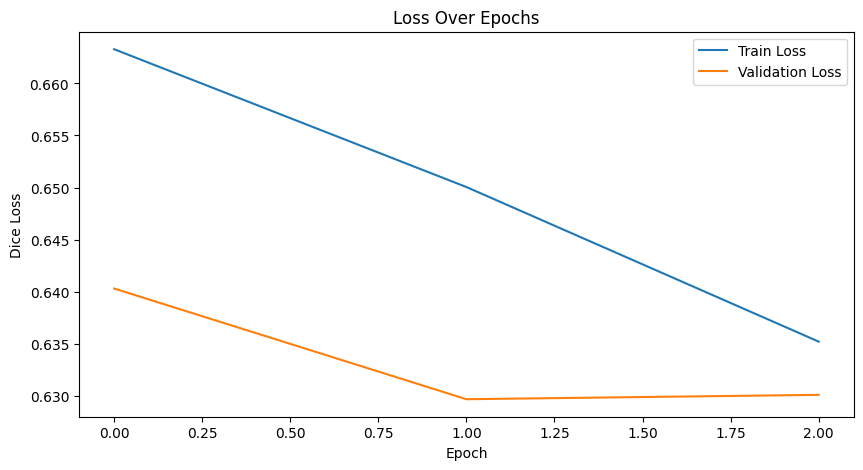

In [24]:
import os
import torch
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, ToTensord, RandRotate90d
)
from monai.data import DataLoader, Dataset
from monai.losses import DiceLoss
from torch.optim import Adam
import matplotlib.pyplot as plt
from monai.data import pad_list_data_collate
from monai.transforms import Resized, SpatialPad
from monai.transforms import RandSpatialCropd 

# MONAI's transforms for dictionary format use 'd' at the end
# Assuming EnsureChannelFirstd is a valid replacement for AddChannel

print("Setting up directories and initial configurations...")

# Directory where the images and labels are stored
data_dir = "z:/W-People/Nate/Deep_Learning_Data/"

# Function to create a list of image and label pairs
def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):  # Identifies the image files
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")  # Creates the label filename
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts
desired_height, desired_width, desired_depth = 64, 64, 64 #REPLACE WITH RANDOM CROP
print("Creating datasets...")
train_files = create_dataset(data_dir)
val_files = create_dataset(data_dir)  # Assuming validation data is in the same directory


# Data Transformations
print("Defining transformations...")
roi_size = (desired_depth, desired_height, desired_width)  # Define the size of the cropped region
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping
    ScaleIntensityd(keys=['image', 'label']),
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ToTensord(keys=['image', 'label']),
])

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping for validation as well
    ScaleIntensityd(keys=['image', 'label']),
    ToTensord(keys=['image', 'label']),
])

train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=pad_list_data_collate)
val_loader = DataLoader(val_ds, batch_size=1, collate_fn=pad_list_data_collate)

# UNet Model Initialization

print("Initializing 3D U-Net model...")

model = UNet(
    spatial_dims=3,  # This specifies that the network should be 3D
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2)
)

# Loss Function and Optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = Adam(model.parameters(), 1e-3)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and Validation Functions
def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0
    for batch_data in loader:
        inputs, targets = batch_data['image'], batch_data['label']
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def validate_epoch(model, loader, loss_function, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch_data in loader:
            inputs, targets = batch_data['image'], batch_data['label']
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# Main Training Loop
train_losses = []
val_losses = []

print("Starting training process...")
num_epochs = 3
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, device)
    val_loss = validate_epoch(model, val_loader, loss_function, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    
# print("Visualizing transformed images...")
# plot_transformed_images(train_loader, num_images=1)

# Plotting loss curves
print("Plotting loss curves...")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()
plt.show()


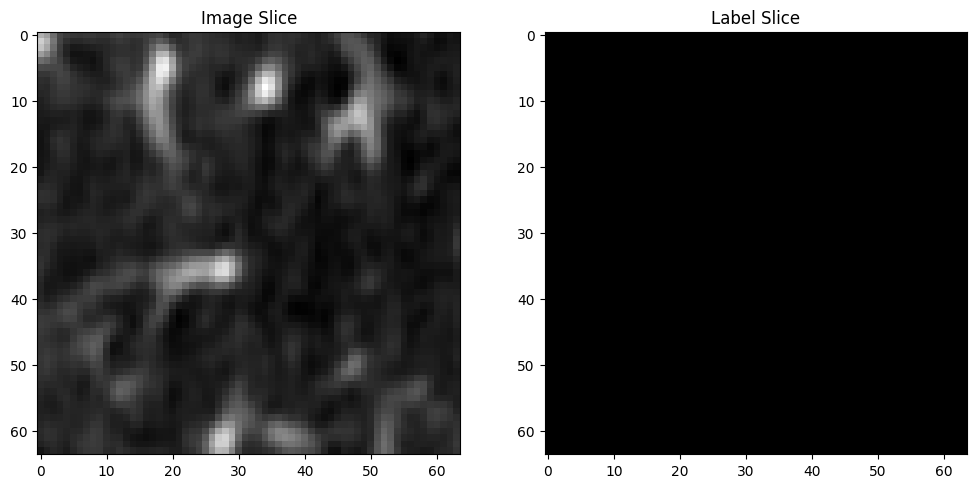

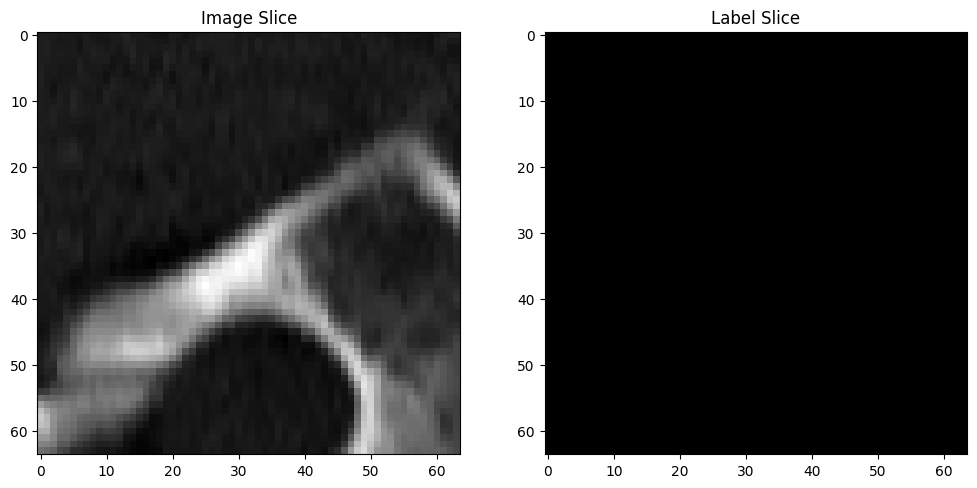

In [25]:
def show_images(batch, slice_index=32, num_images=3):
    images, labels = batch['image'], batch['label']
    for i in range(min(num_images, len(images))):
        plt.figure(figsize=(12, 6))

        # Selecting a slice to display (e.g., the middle slice along the z-axis)
        image_slice = np.squeeze(images[i][0, slice_index, :, :])
        label_slice = np.squeeze(labels[i][0, slice_index, :, :])

        plt.subplot(1, 2, 1)
        plt.imshow(image_slice, cmap='gray')
        plt.title('Image Slice')

        plt.subplot(1, 2, 2)
        plt.imshow(label_slice, cmap='gray')
        plt.title('Label Slice')
        
        plt.show()

# Fetch a batch of data and show images
batch_data = next(iter(train_loader))
show_images(batch_data)


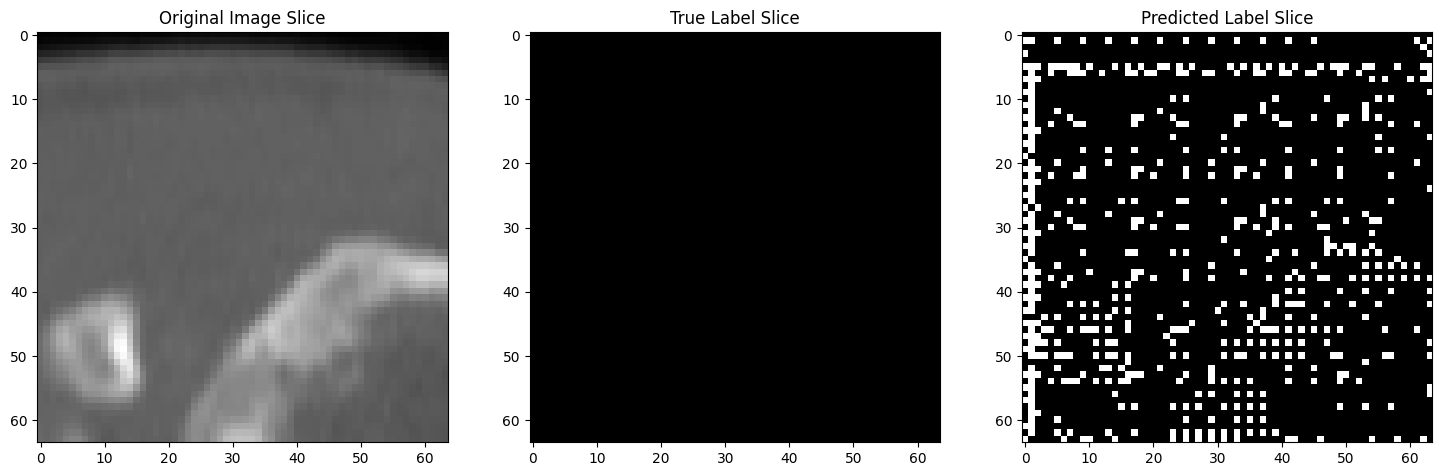

In [26]:
def visualize_predictions(loader, model, device, num_images=3, slice_index=32):
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader))
        inputs, targets = batch['image'], batch['label']
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        # Convert model output to binary predictions
        predicted_labels = outputs.argmax(dim=1, keepdim=True)

        for i in range(min(num_images, len(inputs))):
            plt.figure(figsize=(18, 6))

            # Selecting a slice to display
            input_slice = np.squeeze(inputs[i].cpu()[0, slice_index, :, :])
            target_slice = np.squeeze(targets[i].cpu()[0, slice_index, :, :])
            predicted_slice = np.squeeze(predicted_labels[i].cpu()[0, slice_index, :, :])

            plt.subplot(1, 3, 1)
            plt.imshow(input_slice, cmap='gray')
            plt.title('Original Image Slice')

            plt.subplot(1, 3, 2)
            plt.imshow(target_slice, cmap='gray')
            plt.title('True Label Slice')

            plt.subplot(1, 3, 3)
            plt.imshow(predicted_slice, cmap='gray')
            plt.title('Predicted Label Slice')

            plt.show()

visualize_predictions(val_loader, model, device)


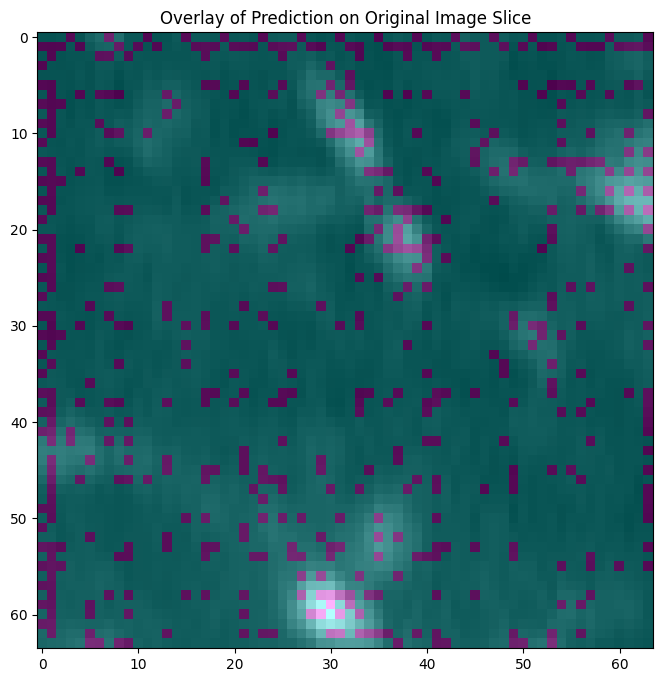

In [28]:
def overlay_predictions(batch, predictions, alpha=0.3, num_images=3, slice_index=32):
    images, labels = batch['image'], batch['label']
    for i in range(min(num_images, len(images))):
        plt.figure(figsize=(8, 8))

        # Selecting a slice to display
        image_slice = np.squeeze(images[i][0, slice_index, :, :])
        prediction_slice = np.squeeze(predictions[i][0, slice_index, :, :])

        plt.imshow(image_slice, cmap='gray')
        plt.imshow(prediction_slice, cmap='cool', alpha=alpha)
        plt.title('Overlay of Prediction on Original Image Slice')
        plt.show()

# Create overlay visualizations
batch_data = next(iter(val_loader))
model.eval()
with torch.no_grad():
    inputs = batch_data['image'].to(device)
    outputs = model(inputs)
    predicted_labels = outputs.argmax(dim=1, keepdim=True).cpu()
    overlay_predictions(batch_data, predicted_labels)


In [4]:
import monai.networks.nets as nets

# List all classes and functions in monai.networks.nets
print(dir(nets))

['AHNet', 'AHnet', 'Ahnet', 'AttentionUnet', 'AutoEncoder', 'BasicUNet', 'BasicUNetPlusPlus', 'BasicUnet', 'BasicUnetPlusPlus', 'Basicunet', 'BasicunetPlusPlus', 'BertAttention', 'BertMixedLayer', 'BertOutput', 'BertPreTrainedModel', 'BlockArgs', 'Classifier', 'Critic', 'DAF3D', 'DenseNet', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'DenseNet264', 'Densenet', 'Densenet121', 'Densenet169', 'Densenet201', 'Densenet264', 'DiNTS', 'Discriminator', 'DynUNet', 'DynUnet', 'Dynunet', 'EfficientNet', 'EfficientNetBN', 'EfficientNetBNFeatures', 'EfficientNetEncoder', 'FLEXUNET_BACKBONE', 'FlexUNet', 'FlexUNetEncoderRegister', 'FlexibleUNet', 'FullyConnectedNet', 'Generator', 'GlobalNet', 'HighResBlock', 'HighResNet', 'HoVerNet', 'HoVernet', 'HoverNet', 'Hovernet', 'LocalNet', 'MILModel', 'MultiModal', 'NetAdapter', 'PatchMerging', 'PatchMergingV2', 'Pooler', 'Quicknat', 'RegUNet', 'Regressor', 'ResNet', 'ResNetBlock', 'ResNetBottleneck', 'SENet', 'SENet154', 'SEResNeXt101', 'SEResNeXt50', 'SER